In [1]:
def slope_reg(arr):
    y = np.array(arr)
    x = np.arange(len(y))
    res = linregress(x, y)
    return res.slope


def stock_filter(df):
    df['sma_30'] = df['c'].rolling(window=30).mean()
    df['sma_50'] = df['c'].rolling(window=50).mean()
    df['sma_150'] = df['c'].rolling(window=150).mean()
    df['sma_200'] = df['c'].rolling(window=200).mean()
    df['sma_slope_200'] = df['sma_200'].rolling(window=200).apply(slope_reg)
    df['52_week_low'] = df['c'].rolling(window=5 * 52).min()
    df['52_week_high'] = df['c'].rolling(window=5 * 52).max()
    df['sma_slope_30'] = df['sma_30'].rolling(window=30).apply(slope_reg)
    
    
    # Criteria 1: The current price of the security must be greater than the 150 and 200-day simple moving averages.
    con1 = (df['c'] > df['sma_150']) & (df['c'] > df['sma_200'])
    
    # Criteria 2: The 150-day simple moving average must be greater than the 200-day simple moving average
    con2 = (df['sma_150'] > df['sma_200'])
    
    # Criteria 3: The 200-day simple moving average must be trending up for at least 1 month.
    con3 = df['sma_slope_200'] > 0
    
    # Criteria 4: The 50-day simple moving average must be greater than the 150 simple moving average and the 200.
    con4 = (df['sma_50'] > df['sma_150']) & (df['sma_50'] > df['sma_200'])
    
    # Criteria 5: The current price must be greater than 50-day simple moving average.
    con5 = (df['c'] > df['sma_50'])
    
    # Criteria 6: The current price must be least 30% above the 52 week low.
    con6 = (df['c'] - df['52_week_low']) / df['52_week_low'] > .3
    
    # Criteria 7: The current price must be within 15% of the 52 week high.
    con7 = abs((df['c'] - df['52_week_high']) / df['52_week_high']) < .15
    
    # Criteria 8: The William O'Neil RS-Rating must be greater than 70 (Undoable)
    con8 = (df['c'] - df['c'].shift(periods=250)) / df['c'].shift(periods=250) > .89
    
    # Criteria 9: Pivot (5 day) Breakout
    con9 = df['c'] > (df['c'].rolling(window=5).mean() + df['c'].rolling(window=5).max() + df['c'].rolling(window=5).min()) / 3
    
    # Criteria 10 Contraction below 10%
    con10 = (df['c'].rolling(window=10).max() - df['c'].rolling(window=10).min()) / df['c'].rolling(window=10).min() < .1
    
    # Criteria 11:
    con11 = df['sma_slope_30'] > 0
    
    con = con1 * con2 * con3 * con4 * con5 * con6 * con7 * con8 * con9 * con10 * con11

    return con

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
df = pd.read_csv('historical_bar_daily.csv')

In [4]:
for s in df.symbol.unique():
    globals()[s] = df[df['symbol'] == s].copy()
    globals()[s].drop(['ab', 'bb', 'expiry', 'right', 'strike', 'instrument'], axis=1, inplace=True)       
    globals()[s]['date'] = globals()[s]['t'].apply(lambda x: str(x)[:10])
    globals()[s]['return'] = globals()[s]['c'].pct_change(1).shift(-1)
    globals()[s].drop(['symbol', 't'], axis=1, inplace=True)
    globals()[s].set_index('date', inplace=True)

In [5]:
vcp_signal = stock_filter(BTCUSD)

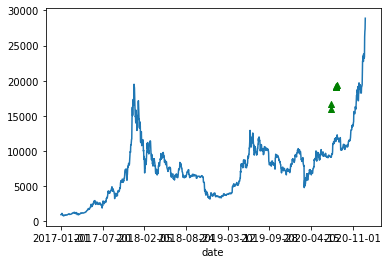

In [11]:
BTCUSD['c'].plot()
plt.scatter(BTCUSD.index, np.where(vcp_signal, BTCUSD['c'], np.nan), marker='^', color='g')

In [13]:
vcp_signal[vcp_signal==True]

date
2020-11-16    True
2020-11-18    True
2020-12-14    True
2020-12-15    True
2020-12-16    True
2020-12-17    True
dtype: bool

In [14]:
BTCUSD.index[-1]

'2021-01-01'

In [51]:
vcp_ret_res = []
vcp_expected_ret_res = []
vcp_sharpe_res = []
window_len = []
symbol_res = []
for sym in df.symbol.unique():
    instrument = globals()[sym]
    vcp_signal = stock_filter(instrument)

    # stop loss
    for l in range(100, 307, 7):
        globals()[f'sma_{l}'] = instrument['c'].rolling(l).mean()
        stop_loss_signal = instrument['c'] < globals()[f'sma_{l}']
        
        hold = False
        rets = []
        for v, r, s in zip(vcp_signal, instrument['return'], stop_loss_signal):
            if v == 1:
                hold = True

            elif s:
                hold = False

            if hold:
                rets.append(r)

        rets = pd.Series(rets).dropna()

        vcp_ret = rets.sum()
        vcp_expected_ret = rets.mean()
        vcp_sharpe = rets.mean() / rets.std()

        vcp_ret_res.append(vcp_ret)
        vcp_expected_ret_res.append(vcp_expected_ret)
        vcp_sharpe_res.append(vcp_sharpe)
        symbol_res.append(sym)
        window_len.append(l)

        del globals()[f'sma_{l}']

C:\Users\Hindy\AppData\Local\Temp\ipykernel_36020\4014576482.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rets = pd.Series(rets).dropna()


In [60]:
res = pd.DataFrame([vcp_ret_res, vcp_expected_ret_res, vcp_sharpe_res, symbol_res, window_len], index=['vcp_ret', 'vcp_expected_ret', 'vcp_sharpe', 'symbol', 'window_len']).T
res.dropna(inplace=True)

In [61]:
res.sort_values('vcp_sharpe', ascending=False)

,vcp_ret,vcp_expected_ret,vcp_sharpe,symbol,window_len
44,0.287104,0.016888,0.386849,BNBUSDT,198
46,0.287104,0.016888,0.386849,BNBUSDT,212
32,0.287104,0.016888,0.386849,BNBUSDT,114
33,0.287104,0.016888,0.386849,BNBUSDT,121
34,0.287104,0.016888,0.386849,BNBUSDT,128
...,...,...,...,...,...
180,-0.398203,-0.015315,-0.298705,ADAUSDT,100
181,-0.398203,-0.015315,-0.298705,ADAUSDT,107
184,-0.398203,-0.015315,-0.298705,ADAUSDT,128
183,-0.398203,-0.015315,-0.298705,ADAUSDT,121


In [62]:
res.groupby('symbol').mean().sort_values('vcp_sharpe', ascending=False)

,vcp_ret,vcp_expected_ret,vcp_sharpe,window_len
symbol,,,,
BNBUSDT,0.287104,0.016888,0.386849,201.5
BTCUSD,0.629669,0.013688,0.360265,201.5
THETAUSDT,1.220812,0.012230,0.177451,201.5
ETHUSD,0.774957,0.005509,0.123665,201.5
XMRUSDT,0.610734,0.005006,0.120251,201.5
LINKUSDT,1.347939,0.007461,0.107460,201.5
ENJUSDT,-0.176839,-0.001779,-0.040000,201.5
BCHUSD,-0.345028,-0.004165,-0.098007,201.5
ADAUSDT,-0.182884,-0.008072,-0.161813,201.5


In [63]:
res.groupby('window_len').mean().sort_values('vcp_sharpe', ascending=False)

C:\Users\Hindy\AppData\Local\Temp\ipykernel_36020\3100004575.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  res.groupby('window_len').mean().sort_values('vcp_sharpe', ascending=False)


,vcp_ret,vcp_expected_ret,vcp_sharpe
window_len,,,
282,0.456134,0.005118,0.106022
268,0.456673,0.005101,0.105842
303,0.452659,0.005096,0.105516
296,0.452659,0.005096,0.105516
289,0.452659,0.005096,0.105516
275,0.454429,0.005092,0.105509
254,0.443495,0.004854,0.098573
261,0.443495,0.004854,0.098573
240,0.443495,0.004854,0.098573
